In [1]:
#import gsw as sw # Gibbs seawater package

from math import *

import matplotlib.pyplot as plt

import matplotlib.colors as mcolors

%matplotlib inline

from MITgcmutils import rdmds

from netCDF4 import Dataset

import numpy as np

import os 

import pylab as pl

import scipy.io

import scipy as spy

import seaborn as sns

import sys

/home/kramosmu/anaconda/lib/python2.7/site-packages/mpl_toolkits/__init__.py:2: UserWarning: Module MITgcmutils was already imported from MITgcmutils/__init__.pyc, but /home/kramosmu/anaconda/lib/python2.7/site-packages/MITgcmutils-0.1.0-py2.7.egg is being added to sys.path
  __import__('pkg_resources').declare_namespace(__name__)


In [2]:
lib_path = os.path.abspath('../../Building_canyon/BuildCanyon/PythonModulesMITgcm') # Add absolute path to my python scripts
sys.path.append(lib_path)

import ReadOutTools_MITgcm as rout 
import TransportTools_MITgcm as trt

In [3]:
def calc_sigmaHor(RhoRef,T,S, At = 2.0E-4, Bs = 7.4E-4):
    '''Calculate sigma as sigma = sigma0 + (RhoRef[Bs(S-S0) - At(T-T0)]) with sigma0 = 0, T0 = 0 and S0 = 0.
       RhoRef: Reference salinity at model layer nz, matching z of T and S.
       T : 2D Temp field (nx,ny) at z
       S : 2D Salt field (nx,ny) at z
       At: Thermal expansion coefficient (units K^-1)
       Bs: Haline expansion coefficient (units ppt^-1)
       
       returns sigma : 2D density anomaly 
    '''
    
    sigma = RhoRef*(Bs*S - At*T)
    return sigma
    

In [4]:
def calc_sigmaVer(RhoRef,T,S, At = 2.0E-4, Bs = 7.4E-4):
    '''Calculate sigma as sigma = sigma0 + (RhoRef[Bs(S-S0) - At(T-T0)]) with sigma0 = 0, T0 = 0 and S0 = 0.
       RhoRef: Reference density profile at nx,ny.
       T : 1D Temp field at nx,ny 
       S : 1D Salt field at nx,ny
       At: Thermal expansion coefficient (units K^-1)
       Bs: Haline expansion coefficient (units ppt^-1)
       
       returns sigma : 1D density anomaly profile
    '''
    
    sigma = RhoRef*(Bs*S - At*T)
    return sigma

In [5]:
sns.set()
sns.set_style('darkgrid')
sns.set_context('notebook')

In [90]:
filename1a='/ocean/kramosmu/MITgcm/CanyonUpwelling/360x360x90_8Tr_LinProfiles_BarkleyHyd_GMREDI/run13/state.0000000000.glob.nc'
StateOuta = Dataset(filename1a)


filename2a='/ocean/kramosmu/MITgcm/CanyonUpwelling/360x360x90_8Tr_LinProfiles_BarkleyHyd_GMREDI/run13/grid.glob.nc'
GridOuta = Dataset(filename2a)

#for dimobj in GridOuta.variables.values():
#    print dimobj

filename3a='/ocean/kramosmu/MITgcm/CanyonUpwelling/360x360x90_8Tr_LinProfiles_BarkleyHyd_GMREDI/run13/ptracers.0000000000.glob.nc'
PtracersOuta = Dataset(filename3a)


filename1b='/ocean/kramosmu/MITgcm/CanyonUpwelling/360x360x90_3Tr_LinProfiles_BarkleyHyd_3DdiffKz/run01/stateGlob.nc'
StateOutb = Dataset(filename1b)


filename2b='/ocean/kramosmu/MITgcm/CanyonUpwelling/360x360x90_3Tr_LinProfiles_BarkleyHyd_3DdiffKz/run01/gridGlob.nc'
GridOutb = Dataset(filename2b)


filename3b='/ocean/kramosmu/MITgcm/CanyonUpwelling/360x360x90_3Tr_LinProfiles_BarkleyHyd_3DdiffKz/run01/ptracersGlob.nc'
PtracersOutb = Dataset(filename3b)

RhoRefa = np.squeeze(rdmds('/ocean/kramosmu/MITgcm/CanyonUpwelling/360x360x90_8Tr_LinProfiles_BarkleyHyd_GMREDI/run13/RhoRef'))
RhoRefb = np.squeeze(rdmds('/ocean/kramosmu/MITgcm/CanyonUpwelling/360x360x90_3Tr_LinProfiles_BarkleyHyd_3DdiffKz/run01/RhoRef'))

/ocean/kramosmu/MITgcm/CanyonUpwelling/360x360x90_8Tr_LinProfiles_BarkleyHyd_GMREDI/run13/RhoRef.meta
/ocean/kramosmu/MITgcm/CanyonUpwelling/360x360x90_3Tr_LinProfiles_BarkleyHyd_3DdiffKz/run01/RhoRef.meta


In [116]:
# General input

nx = 360
ny = 360
nz = 90

nt = 19 # t dimension size 

Bs = 7.4E-4 # ppt^-1
At = 2.0E-4 # K^-1

z = StateOuta.variables['Z']
#print(z[10])
Time = StateOuta.variables['T']
#print(Time[:])
xc = rout.getField(filename2a, 'XC') # x coords tracer cells
yc = rout.getField(filename2a, 'YC') # y coords tracer cells

drF = GridOuta.variables['drF'] # vertical distance between faces
dxG = rout.getField(filename2a,'dxG')
bathy = rout.getField(filename2a, 'Depth')

rA = rout.getField(filename2a, 'rA') # area of cells (x-y)
hFacC = rout.getField(filename2a, 'HFacC')
MaskC = rout.getMask(filename2a,'HFacC') # same for both runs

In [8]:
Tempa = rout.getField(filename1a,'Temp') # T and S of CNT run (run13)
Salta = rout.getField(filename1a,'S')

In [9]:
Tempb = rout.getField(filename1b,'Temp') # T and S of Kzdiff3D run (run01)
Saltb = rout.getField(filename1b,'S')

In [10]:
Bs = 7.4E-4 # Haline and thermal expansion coefficients of linear EoS
At = 2.0E-4


In [11]:
Tr1CNT = rout.getField(filename3a,'Tr1') # Tracer 1 CNT run , Kz = E-5
Tr2CNT = rout.getField(filename3a,'Tr2') # Tracer 2 CNT run , Kz = E-3
Tr13D = rout.getField(filename3b,'Tr1') # Tracer 1 KzDiff3D run , Kz_cny = E-3, Kz_out = E-5


In [12]:
filename1c='/ocean/kramosmu/MITgcm/CanyonUpwelling/360x360x90_8Tr_LinProfiles_BarkleyHyd_GMREDI/run17/stateGlob.nc'
StateOutc = Dataset(filename1c)

filename2c='/ocean/kramosmu/MITgcm/CanyonUpwelling/360x360x90_8Tr_LinProfiles_BarkleyHyd_GMREDI/run17/gridGlob.nc'
GridOutc = Dataset(filename2c)

filename3c='/ocean/kramosmu/MITgcm/CanyonUpwelling/360x360x90_8Tr_LinProfiles_BarkleyHyd_GMREDI/run17/ptracersGlob.nc'
PtracersOutc = Dataset(filename3c)

RhoRefc = np.squeeze(rdmds('/ocean/kramosmu/MITgcm/CanyonUpwelling/360x360x90_8Tr_LinProfiles_BarkleyHyd_GMREDI/run17/RhoRef'))


/ocean/kramosmu/MITgcm/CanyonUpwelling/360x360x90_8Tr_LinProfiles_BarkleyHyd_GMREDI/run17/RhoRef.meta


In [13]:
Tr1NoC = rout.getField(filename3c,'Tr1')
Tr2NoC = rout.getField(filename3c,'Tr2')

TempNoC = rout.getField(filename1c,'Temp')
SaltNoC = rout.getField(filename1c,'S')

MaskNoC = rout.getMask(filename2c,'HFacC') 
hFacCNoC = rout.getField(filename2c,'HFacC') 
rANoC = rout.getField(filename2c,'rA') 

In [14]:
drFNoC= GridOutc.variables['drF']

### How much water with tracer concentration >= C[zi=27, x,y in open water] is there on the shelf at a given time? How much water with density >= $\rho$[zi=27, x,y in open water] is there on the shelf at a given time? How much tracer?

/home/kramosmu/anaconda/lib/python2.7/site-packages/matplotlib/text.py:52: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if rotation in ('horizontal', None):
/home/kramosmu/anaconda/lib/python2.7/site-packages/matplotlib/text.py:54: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  elif rotation == 'vertical':


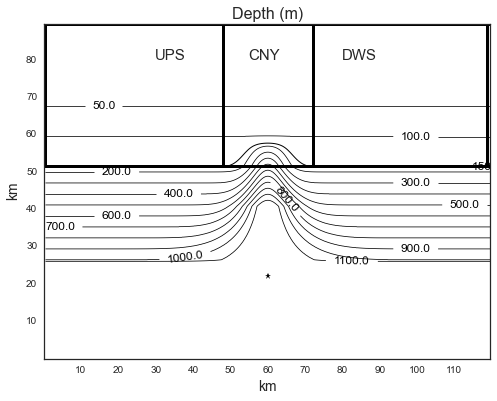

In [15]:
plt.rcParams.update({'font.size': 15})

fig = plt.figure(figsize=(8,6))
sns.set_style('white')
### Across-Shelf Planes ###
plt.plot(xc[197:,120],yc[197:,120],'-', linewidth=3, linestyle='-', color='0.0')
plt.plot(xc[197:,240],yc[197:,240],'-',linewidth=3, linestyle='-', color='0.0' )

### Along Shelf Planes ###
plt.plot(xc[197,:120],yc[197,:120],'-',linewidth=3, linestyle='-', color='0.0' )
plt.plot(xc[197,120:240],yc[197,120:240],'-',linewidth=3, linestyle='-', color='0.0' )
plt.plot(xc[197,240:360],yc[197,240:360],'-',linewidth=3, linestyle='-', color='0.0' )


plt.plot(xc[359,:],yc[359,:],'-',linewidth=3, linestyle='-', color='0.0' )
plt.plot(xc[197:,358],yc[197:,358],'-',linewidth=3, linestyle='-', color='0.0' )
plt.plot(xc[197:,0],yc[197:,0],'-',linewidth=3, linestyle='-', color='0.0' )

plt.plot(xc[50,180],yc[50,180],'k*' )

lev = range(200,1200,100)

levels = [50,100,150]+lev

CS = plt.contour(xc,yc,bathy,levels,colors='k',linewidths=[0.75,0.75,1,0.75,0.75,0.75,0.75,0.75,0.75,0.75,0.75,0.75,0.75] )

plt.clabel(CS, 
           inline=1,
          fmt='%1.1f',
           fontsize=12)


plt.xticks(np.arange(0,120000,10000), [' ','10','20','30','40','50','60','70','80','90','100','110','120'])
plt.yticks(np.arange(0,90000,10000), [' ','10','20','30','40','50','60','70','80','90'])

plt.xlabel('km',fontsize=14)
plt.ylabel('km',fontsize=14)

plt.title('Depth (m)',fontsize=16)

plt.annotate('UPS', xy=(30000, 80000), xytext=(30000, 80000))

plt.annotate('CNY', xy=(55000, 80000), xytext=(55000, 80000))

plt.annotate('DWS', xy=(80000, 80000), xytext=(80000, 80000))



#plt.savefig('/ocean/kramosmu/Figures/WaterVolumeOverShelf/UPS_CNY_DNS_map.eps', format='eps', dpi=1000,bbox_extra_artists=(leg,), bbox_inches='tight')


The idea is to calculate the amount of water with certain characteristics is inside each box (UPS,CNY,DWN) at each day. This boxes go from shelf break depth all the way to the surface. The y index of the shelf is 197, z index is 28. The mask to be used should be the one for the no canyon case, otherwise the water within the canyon at z[28] would be taken into account.


In [16]:
def HowMuchWaterRho(Temp,Salt,MaskC,RhoRef,nzlim,Bs,At,rA,hFacC,drF):
    '''nzlim  is the nz index under which to look for water properties
    '''

    TotWaterUPSRho= np.zeros(nt)
    TotUPSTr= np.zeros(nt)
  
    TotWaterCNYRho= np.zeros(nt)
    TotCNYTr= np.zeros(nt)
    
    TotWaterDNSRho= np.zeros(nt)
    TotDNSTr= np.zeros(nt)
    RhoRef1 = np.empty((90,360,360))
    RhoRef1[:] = RhoRef
    
    TempMask0=np.ma.array(Temp[0,:,:,:],mask=MaskC[:,:,:])
    SaltMask0=np.ma.array(Salt[0,:,:,:],mask=MaskC[:,:,:])
        
    rholim = RhoRef1[nzlim]*(Bs*SaltMask0[nzlim,50,180] - At*TempMask0[nzlim,50,180] )
    
    print('density limit is: ',rholim)
    
    for tt in range(0,nt,1) :
        
        TempMask=np.ma.array(Temp[tt,:,:,:],mask=MaskC[:,:,:])
        SaltMask=np.ma.array(Salt[tt,:,:,:],mask=MaskC[:,:,:])
        
        TempMask=np.ma.array(Temp[tt,:,:,:],mask=MaskC[:,:,:])
        SaltMask=np.ma.array(Salt[tt,:,:,:],mask=MaskC[:,:,:])
        
        sigma = RhoRef1*(Bs*SaltMaskb - At*TempMaskb)
        #Box UPS
        for ii,trac in np.ndenumerate(TrMask[:,197:,:120]) :
            if trac >= rholim:
                TotWaterUPSRho[tt] = TotWaterUPSRho[tt] + hFacC[ii]*drF[ii[0]]*rA[ii[1],ii[2]]
                TotUPSTr[tt] = TotUPSTr[tt]+hFacC[ii]*drF[ii[0]]*rA[ii[1],ii[2]]*trac
        
        #Box CNY
        for ii,trac in np.ndenumerate(TrMask[:,197:,120:240]) :
            if trac >= rholim:
                TotWaterCNYRho[tt] = TotWaterCNYRho[tt] + hFacC[ii]*drF[ii[0]]*rA[ii[1],ii[2]]
                TotCNYTr[tt] = TotCNYTr[tt] + hFacC[ii]*drF[ii[0]]*rA[ii[1],ii[2]]*trac
             
        #Box CNY
        for ii,trac in np.ndenumerate(TrMask[:,197:,240:]) :
            if trac >= rholim:
                TotWaterDNSRho[tt] = TotWaterDNSRho[tt] + hFacC[ii]*drF[ii[0]]*rA[ii[1],ii[2]]
                TotDNSTr[tt] = TotDNSTr[tt] + hFacC[ii]*drF[ii[0]]*rA[ii[1],ii[2]]*trac
         
    return(TotWaterUPSRho,TotUPSTr,TotWaterCNYRho,TotCNYTr,TotWaterDNSRho,TotDNSTr)
            
     

In [107]:
def HowMuchWater(Tr,MaskC,nzlim,rA,hFacC,drF):
    '''
    INPUT----------------------------------------------------------------------------------------------------------------
    Tr    : Array with concentration values for a tracer. Until this function is more general, this should be size 19x90x360x360
    MaskC : Land mask for tracer
    nzlim : The nz index under which to look for water properties
    rA    : Area of cell faces at C points (360x360)
    fFacC : Fraction of open cell (90x360x360)
    drF   : Distance between cell faces (90)
    
    OUTPUT----------------------------------------------------------------------------------------------------------------
    TotWaterUPSTr,TotWaterCNYTr,TotWaterDNSTr = (19) Arrays with the volume of water inside each box (UPS,CNY,DNS) with 
                                                concentration higer or equal than a caoncentration Tr[nzlim].
    TotUPSTr,TotCNYTr,TotDNSTr = (19) Arrays with the mass of tracer (umol) inside each box (UPS,CNY,DNS). Total mass of tracer.
                                                
    -----------------------------------------------------------------------------------------------------------------------
    '''

    TotWaterUPSTr= np.zeros(nt)
    TotUPSTr= np.zeros(nt)
  
    TotWaterCNYTr= np.zeros(nt)
    TotCNYTr= np.zeros(nt)
    
    TotWaterDNSTr= np.zeros(nt)
    TotDNSTr= np.zeros(nt)
    
    TrMask0=np.ma.array(Tr[0,:,:,:],mask=MaskC[:,:,:])
        
    trlim = TrMask0[nzlim,50,180]
    
    hFacCSwap = np.swapaxes(hFacC, 0, 2)
    
    VolUPS = (np.swapaxes(hFacCSwap[:120,197:,:28]*drF[:28],0,2))*rA[197:,:120]
    VolCNY = (np.swapaxes(hFacCSwap[120:240,197:,:28]*drF[:28],0,2))*rA[197:,120:240]
    VolDNS = (np.swapaxes(hFacCSwap[240:,197:,:28]*drF[:28],0,2))*rA[197:,240:]
    
    print('tracer limit is: ',trlim)
    for tt in range(0,nt,1) :
        
        TrMask=np.ma.array(Tr[tt,:,:,:],mask=MaskC[:,:,:])
    
        
        #Box UPS
        for ii,trac in np.ndenumerate(TrMask[:28,197:,:120]) :
            if trac >= trlim:
                TotWaterUPSTr[tt] = TotWaterUPSTr[tt] + hFacC[ii]*drF[ii[0]]*rA[ii[1],ii[2]]
                
        TotUPSTr[tt] = np.sum(VolUPS*TrMask[:28,197:,:120]*1000.0) #[1 umol/l=1000 umol/m^3]
        
        #Box CNY
        for ii,trac in np.ndenumerate(TrMask[:28,197:,120:240]) :
            if trac >= trlim:
                TotWaterCNYTr[tt] = TotWaterCNYTr[tt] + hFacC[ii]*drF[ii[0]]*rA[ii[1],ii[2]]
            
        TotCNYTr[tt] = np.sum(VolCNY*TrMask[:28,197:,120:240]*1000.0) #[1 umol/l=1000 umol/m^3]
             
        #Box DNS
        for ii,trac in np.ndenumerate(TrMask[:28,197:,240:]) :
            if trac >= trlim:
                TotWaterDNSTr[tt] = TotWaterDNSTr[tt] + hFacC[ii]*drF[ii[0]]*rA[ii[1],ii[2]]
            
        TotDNSTr[tt] = np.sum(VolDNS*TrMask[:28,197:,240:]*1000.0) #[1 umol/l=1000 umol/m^3]
         
    return(TotWaterUPSTr,TotUPSTr,TotWaterCNYTr,TotCNYTr,TotWaterDNSTr,TotDNSTr)
            

In [38]:
TotWaterUPSTr,TotUPSTr,TotWaterCNYTr,TotCNYTr,TotWaterDNSTr,TotDNSTr=HowMuchWater(Tr1CNT,MaskNoC,30,rA,hFacCNoC,drFNoC)

TotWaterUPSTrNoC,TotUPSTrNoC,TotWaterCNYTrNoC,TotCNYTrNoC,TotWaterDNSTrNoC,TotDNSTrNoC=HowMuchWater(Tr1NoC,MaskNoC,30,rANoC,hFacCNoC,drFNoC)

TotWaterUPSTr3D,TotUPSTr3D,TotWaterCNYTr3D,TotCNYTr3D,TotWaterDNSTr3D,TotDNSTr3D=HowMuchWater(Tr13D,MaskNoC,30,rA,hFacCNoC,drFNoC)


('tracer limit is: ', 7.3974895)
('tracer limit is: ', 7.3974895)
('tracer limit is: ', 7.3974895)


In [39]:
TotWaterUPSTr2NoC,TotUPSTr2NoC,TotWaterCNYTr2NoC,TotCNYTr2NoC,TotWaterDNSTr2NoC,TotDNSTr2NoC=HowMuchWater(Tr2NoC,MaskNoC,30,rANoC,hFacCNoC,drFNoC)

TotWaterUPSTr2,TotUPSTr2,TotWaterCNYTr2,TotCNYTr2,TotWaterDNSTr2,TotDNSTr2=HowMuchWater(Tr2CNT,MaskNoC,30,rA,hFacCNoC,drFNoC)


('tracer limit is: ', 7.3974895)
('tracer limit is: ', 7.3974895)


('Total volume ($m^3$) on UPS is :', 102262897920.0)
('Total volume ($m^3$) on CNY is :', 51131448959.999985)
('Total volume ($m^3$) on DNS is :', 102262897920.00006)
('Total volume ($m^3$) on UPSNoC is :', 102262897920.0)
('Total volume ($m^3$) on CNYNoC is :', 51131448959.999985)
('Total volume ($m^3$) on DNSNoC is :', 102262897920.00006)


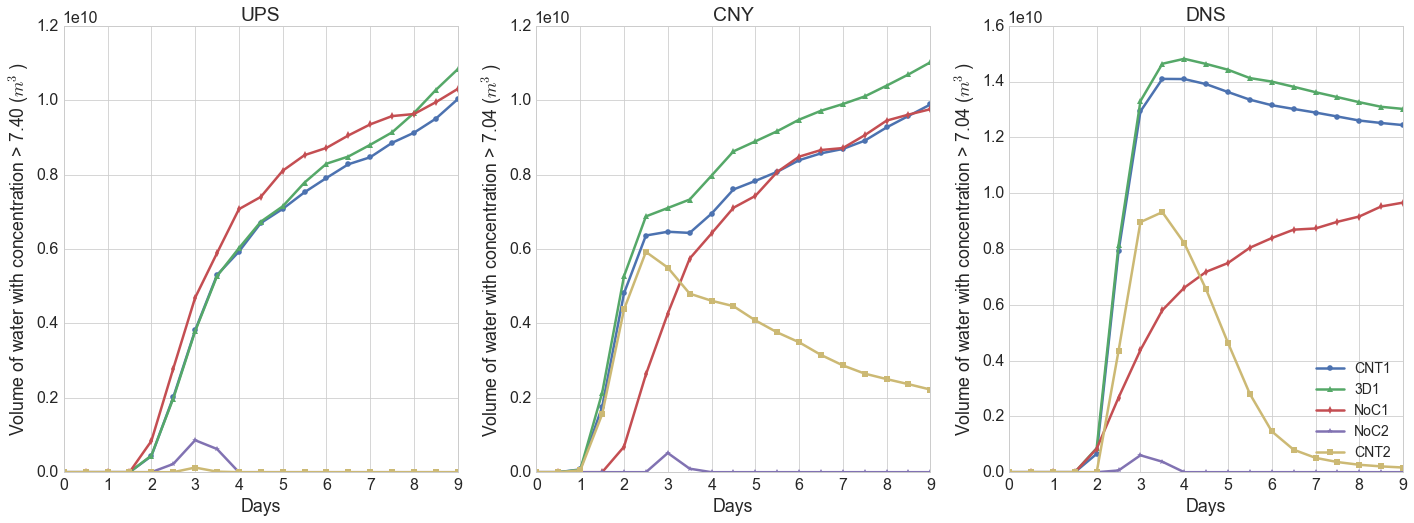

In [47]:
fig45=plt.figure(figsize=(24,8))
sns.set_style('whitegrid')

plt.subplot(1,3,1)
ax = plt.gca()


plt.plot(np.linspace(0,9,19),TotWaterUPSTr,'o-',label=('CNT1' ))
plt.plot(np.linspace(0,9,19),TotWaterUPSTr3D,'^-',label=('3D1'))
plt.plot(np.linspace(0,9,19),TotWaterUPSTrNoC,'d-',label=('NoC1' ))
plt.plot(np.linspace(0,9,19),TotWaterUPSTr2NoC,'*-',label=('NoC2' ))
plt.plot(np.linspace(0,9,19),TotWaterUPSTr2,'s-',label=('CNT2' ))

plt.ylabel('Volume of water with concentration > 7.40 ($m^3$)')
plt.xlabel('Days')
plt.title('UPS')
##### 
plt.subplot(1,3,2)
ax = plt.gca()

plt.plot(np.linspace(0,9,19),TotWaterCNYTr,'o-',label=('NCT1' ))
plt.plot(np.linspace(0,9,19),TotWaterCNYTr3D,'^-',label=('3D1'))
plt.plot(np.linspace(0,9,19),TotWaterCNYTrNoC,'d-',label=('NoC1' ))
plt.plot(np.linspace(0,9,19),TotWaterCNYTr2NoC,'*-',label=('NoC2' ))
plt.plot(np.linspace(0,9,19),TotWaterCNYTr2,'s-',label=('CNT2' ))

plt.ylabel('Volume of water with concentration > 7.04 ($m^3$) ')
plt.xlabel('Days')
plt.title('CNY')

######
plt.subplot(1,3,3)
ax = plt.gca()


plt.plot(np.linspace(0,9,19),TotWaterDNSTr,'o-',label=('CNT1' ))
plt.plot(np.linspace(0,9,19),TotWaterDNSTr3D,'^-',label=('3D1'))
plt.plot(np.linspace(0,9,19),TotWaterDNSTrNoC,'d-',label=('NoC1' ))
plt.plot(np.linspace(0,9,19),TotWaterDNSTr2NoC,'*-',label=('NoC2' ))
plt.plot(np.linspace(0,9,19),TotWaterDNSTr2,'s-',label=('CNT2' ))

plt.ylabel('Volume of water with concentration > 7.04 ($m^3$)')
plt.xlabel('Days')
plt.title('DNS')
plt.legend(loc=4, fontsize=14)

##########################################################################
hFacCSwap = np.swapaxes(hFacC, 0, 2)
hFacCNoCSwap = np.swapaxes(hFacCNoC, 0, 2)

TotVolUPS = np.sum(np.sum(np.sum((np.swapaxes(hFacCNoCSwap[:120,197:,:28]*drF[:28],0,2))*rA[197:,:120],axis=0),axis=0),axis=0)
TotVolCNY = np.sum(np.sum(np.sum((np.swapaxes(hFacCNoCSwap[120:240,197:,:28]*drF[:28],0,2))*rA[197:,120:240],axis=0),axis=0),axis=0)
TotVolDNS = np.sum(np.sum(np.sum((np.swapaxes(hFacCNoCSwap[240:,197:,:28]*drF[:28],0,2))*rA[197:,240:],axis=0),axis=0),axis=0)

TotVolUPSNoC = np.sum(np.sum(np.sum((np.swapaxes(hFacCNoCSwap[:120,197:,:28]*drF[:28],0,2))*rANoC[197:,:120],axis=0),axis=0),axis=0)
TotVolCNYNoC = np.sum(np.sum(np.sum((np.swapaxes(hFacCNoCSwap[120:240,197:,:28]*drF[:28],0,2))*rANoC[197:,120:240],axis=0),axis=0),axis=0)
TotVolDNSNoC = np.sum(np.sum(np.sum((np.swapaxes(hFacCNoCSwap[240:,197:,:28]*drF[:28],0,2))*rANoC[197:,240:],axis=0),axis=0),axis=0)


print('Total volume ($m^3$) on UPS is :', TotVolUPS)  
print('Total volume ($m^3$) on CNY is :', TotVolCNY)  
print('Total volume ($m^3$) on DNS is :', TotVolDNS)  
print('Total volume ($m^3$) on UPSNoC is :', TotVolUPSNoC)  
print('Total volume ($m^3$) on CNYNoC is :', TotVolCNYNoC)  
print('Total volume ($m^3$) on DNSNoC is :', TotVolDNSNoC)  

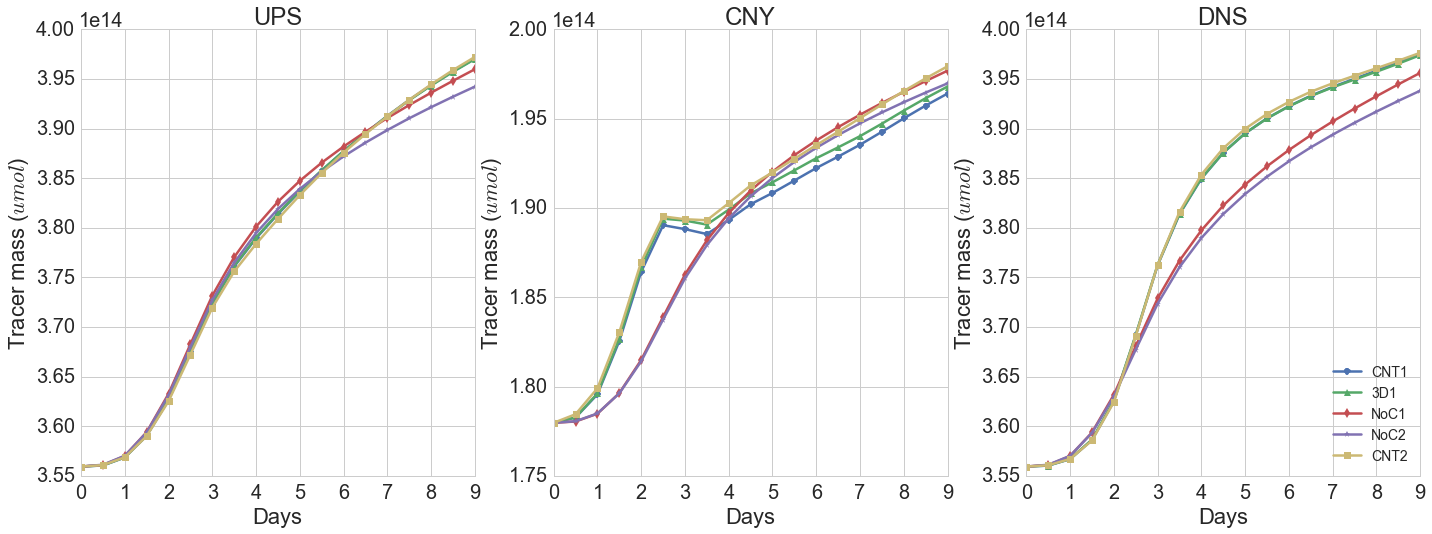

In [55]:
fig45=plt.figure(figsize=(24,8))
sns.set(context='notebook', style='whitegrid', font='sans-serif', font_scale=2, rc={"lines.linewidth": 2.5})

plt.subplot(1,3,1)
ax = plt.gca()


plt.plot(np.linspace(0,9,19),TotUPSTr,'o-',label=('CNT1' ))
plt.plot(np.linspace(0,9,19),TotUPSTr3D,'^-',label=('3D1'))
plt.plot(np.linspace(0,9,19),TotUPSTrNoC,'d-',label=('NoC1' ))
plt.plot(np.linspace(0,9,19),TotUPSTr2NoC,'*-',label=('NoC2' ))
plt.plot(np.linspace(0,9,19),TotUPSTr2,'s-',label=('CNT2' ))

plt.ylabel('Tracer mass ($umol$)')
plt.xlabel('Days')
plt.title('UPS')
##### 
plt.subplot(1,3,2)
ax = plt.gca()


plt.plot(np.linspace(0,9,19),TotCNYTr,'o-',label=('NCT1' ))
plt.plot(np.linspace(0,9,19),TotCNYTr3D,'^-',label=('3D1'))
plt.plot(np.linspace(0,9,19),TotCNYTrNoC,'d-',label=('NoC1' ))
plt.plot(np.linspace(0,9,19),TotCNYTr2NoC,'*-',label=('NoC2' ))
plt.plot(np.linspace(0,9,19),TotCNYTr2,'s-',label=('CNT2' ))

plt.ylabel('Tracer mass ($umol$)')
plt.xlabel('Days')
plt.title('CNY')

######
plt.subplot(1,3,3)
ax = plt.gca()


plt.plot(np.linspace(0,9,19),TotDNSTr,'o-',label=('CNT1' ))
plt.plot(np.linspace(0,9,19),TotDNSTr3D,'^-',label=('3D1'))
plt.plot(np.linspace(0,9,19),TotDNSTrNoC,'d-',label=('NoC1' ))
plt.plot(np.linspace(0,9,19),TotDNSTr2NoC,'*-',label=('NoC2' ))
plt.plot(np.linspace(0,9,19),TotDNSTr2,'s-',label=('CNT2' ))

plt.ylabel('Tracer mass ($umol$)')
plt.xlabel('Days')
plt.title('DNS')
plt.legend(loc=4, fontsize=14)

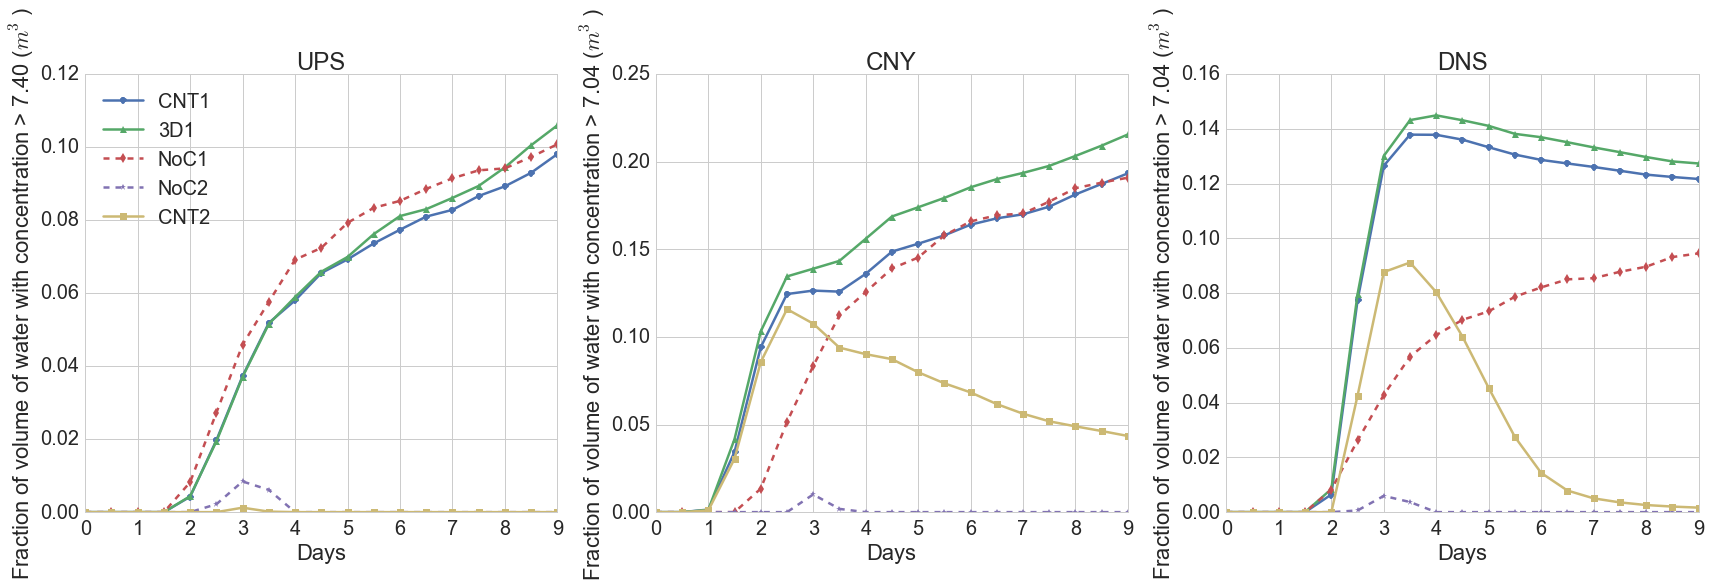

In [50]:
fig45=plt.figure(figsize=(24,8))
 
sns.set(context='notebook', style='whitegrid', font='sans-serif', font_scale=2, rc={"lines.linewidth": 2.5})


plt.subplot(1,3,1)
ax = plt.gca()
    

plt.plot(np.linspace(0,9,19),TotWaterUPSTr/TotVolUPS,'o-',label=('CNT1' ))
plt.plot(np.linspace(0,9,19),TotWaterUPSTr3D/TotVolUPS,'^-',label=('3D1'))
plt.plot(np.linspace(0,9,19),TotWaterUPSTrNoC/TotVolUPS,'d--',label=('NoC1' ))
plt.plot(np.linspace(0,9,19),TotWaterUPSTr2NoC/TotVolUPS,'*--',label=('NoC2' ))
plt.plot(np.linspace(0,9,19),TotWaterUPSTr2/TotVolUPS,'s-',label=('CNT2' ))

plt.ylabel('Fraction of volume of water with concentration > 7.40 ($m^3$)')
plt.xlabel('Days')
plt.title('UPS')
leg = plt.legend(loc=0)
##### 
plt.subplot(1,3,2)
ax = plt.gca()
    

plt.plot(np.linspace(0,9,19),TotWaterCNYTr/TotVolCNY,'o-',label=('NCT1' ))
plt.plot(np.linspace(0,9,19),TotWaterCNYTr3D/TotVolCNY,'^-',label=('3D1'))
plt.plot(np.linspace(0,9,19),TotWaterCNYTrNoC/TotVolCNY,'d--',label=('NoC1' ))
plt.plot(np.linspace(0,9,19),TotWaterCNYTr2NoC/TotVolCNY,'*--',label=('NoC2' ))
plt.plot(np.linspace(0,9,19),TotWaterCNYTr2/TotVolCNY,'s-',label=('CNT2' ))

plt.ylabel('Fraction of volume of water with concentration > 7.04 ($m^3$) ')
plt.xlabel('Days')
plt.title('CNY')

######
plt.subplot(1,3,3)
ax = plt.gca()
    

plt.plot(np.linspace(0,9,19),TotWaterDNSTr/TotVolDNS,'o-',label=('CNT1, $DiffKz = 10^{-5}$' ))
plt.plot(np.linspace(0,9,19),TotWaterDNSTr3D/TotVolDNS,'^-',label=('3D1, $DiffKz_{cny} = 10^{-3}$ \n ,$DiffKz_{out} = 10^{-5}$ '))
plt.plot(np.linspace(0,9,19),TotWaterDNSTrNoC/TotVolDNS,'d--',label=('NoC1, $DiffKz = 10^{-3}$' ))
plt.plot(np.linspace(0,9,19),TotWaterDNSTr2NoC/TotVolDNS,'*--',label=('NoC2, $DiffKz = 10^{-3}$' ))
plt.plot(np.linspace(0,9,19),TotWaterDNSTr2/TotVolDNS,'s-',label=('CNT2, $DiffKz = 10^{-3}$' ))

plt.ylabel('Fraction of volume of water with concentration > 7.04 ($m^3$)')
plt.xlabel('Days')
plt.title('DNS')
    
plt.tight_layout()
fig45.subplots_adjust(top=0.9)
#fig45.savefig('/ocean/kramosmu/Figures/WaterVolumeOverShelf/H2OVolOver_UPS_CNY_DNS_noCnyandCny.eps', format='eps', dpi=1000,bbox_extra_artists=(leg,), bbox_inches='tight')




In [51]:
TotWaterUPSTr32,TotUPSTr32,TotWaterCNYTr32,TotCNYTr32,TotWaterDNSTr32,TotDNSTr32=HowMuchWater(Tr1CNT,MaskNoC,32,rA,hFacCNoC,drFNoC)

TotWaterUPSTrNoC32,TotUPSTrNoC32,TotWaterCNYTrNoC32,TotCNYTrNoC32,TotWaterDNSTrNoC32,TotDNSTrNoC32=HowMuchWater(Tr1NoC,MaskNoC,32,rANoC,hFacCNoC,drFNoC)

TotWaterUPSTr3D32,TotUPSTr3D32,TotWaterCNYTr3D32,TotCNYTr3D32,TotWaterDNSTr3D32,TotDNSTr3D32=HowMuchWater(Tr13D,MaskNoC,32,rA,hFacCNoC,drFNoC)

TotWaterUPSTr2NoC32,TotUPSTr2NoC32,TotWaterCNYTr2NoC32,TotCNYTr2NoC32,TotWaterDNSTr2NoC32,TotDNSTr2NoC32=HowMuchWater(Tr2NoC,MaskNoC,32,rANoC,hFacCNoC,drFNoC)

TotWaterUPSTr232,TotUPSTr232,TotWaterCNYTr232,TotCNYTr232,TotWaterDNSTr232,TotDNSTr232=HowMuchWater(Tr2CNT,MaskNoC,32,rA,hFacCNoC,drFNoC)


('tracer limit is: ', 7.7573223)
('tracer limit is: ', 7.7573223)
('tracer limit is: ', 7.7573223)
('tracer limit is: ', 7.7573223)
('tracer limit is: ', 7.7573223)


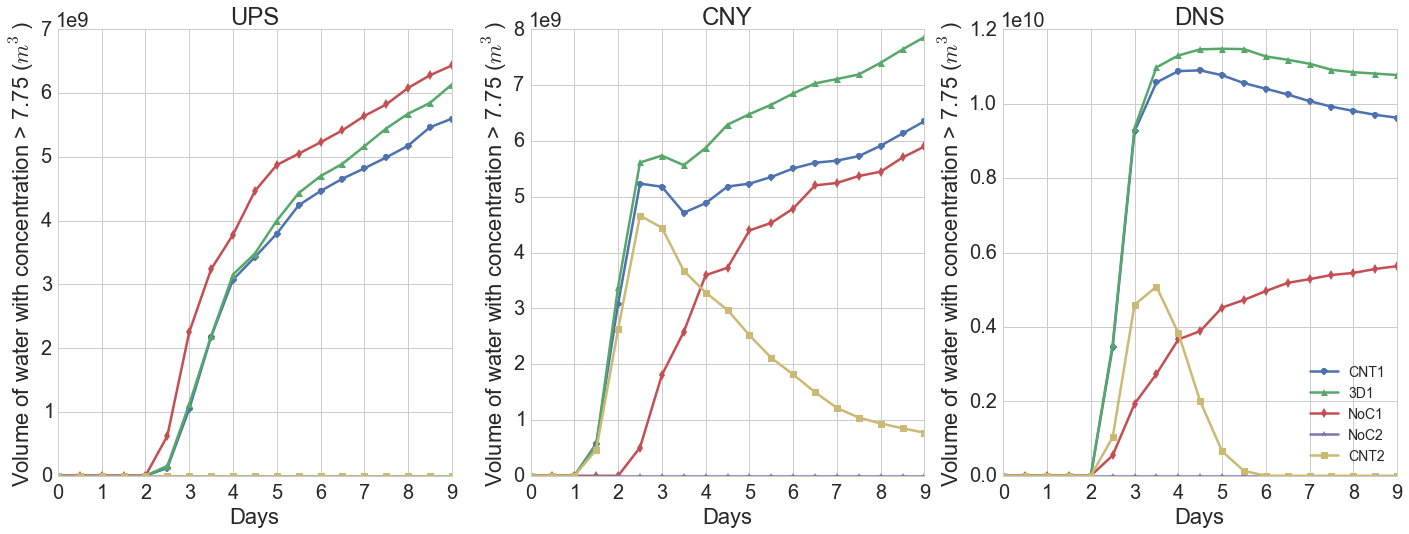

In [54]:
fig45=plt.figure(figsize=(24,8))
sns.set_style('whitegrid')

plt.subplot(1,3,1)
ax = plt.gca()


plt.plot(np.linspace(0,9,19),TotWaterUPSTr32,'o-',label=('CNT1' ))
plt.plot(np.linspace(0,9,19),TotWaterUPSTr3D32,'^-',label=('3D1'))
plt.plot(np.linspace(0,9,19),TotWaterUPSTrNoC32,'d-',label=('NoC1' ))
plt.plot(np.linspace(0,9,19),TotWaterUPSTr2NoC32,'*-',label=('NoC2' ))
plt.plot(np.linspace(0,9,19),TotWaterUPSTr232,'s-',label=('CNT2' ))

plt.ylabel('Volume of water with concentration > 7.75 ($m^3$)')
plt.xlabel('Days')
plt.title('UPS')
##### 
plt.subplot(1,3,2)
ax = plt.gca()

plt.plot(np.linspace(0,9,19),TotWaterCNYTr32,'o-',label=('NCT1' ))
plt.plot(np.linspace(0,9,19),TotWaterCNYTr3D32,'^-',label=('3D1'))
plt.plot(np.linspace(0,9,19),TotWaterCNYTrNoC32,'d-',label=('NoC1' ))
plt.plot(np.linspace(0,9,19),TotWaterCNYTr2NoC32,'*-',label=('NoC2' ))
plt.plot(np.linspace(0,9,19),TotWaterCNYTr232,'s-',label=('CNT2' ))

plt.ylabel('Volume of water with concentration > 7.75 ($m^3$) ')
plt.xlabel('Days')
plt.title('CNY')

######
plt.subplot(1,3,3)
ax = plt.gca()

plt.plot(np.linspace(0,9,19),TotWaterDNSTr32,'o-',label=('CNT1' ))
plt.plot(np.linspace(0,9,19),TotWaterDNSTr3D32,'^-',label=('3D1'))
plt.plot(np.linspace(0,9,19),TotWaterDNSTrNoC32,'d-',label=('NoC1' ))
plt.plot(np.linspace(0,9,19),TotWaterDNSTr2NoC32,'*-',label=('NoC2' ))
plt.plot(np.linspace(0,9,19),TotWaterDNSTr232,'s-',label=('CNT2' ))

plt.ylabel('Volume of water with concentration > 7.75 ($m^3$)')
plt.xlabel('Days')
plt.title('DNS')
plt.legend(loc=4, fontsize=14)


In [114]:
def HowMuchWaterX(Tr,MaskC,nzlim,rA,hFacC,drF,tt,nx,dx):
    '''
    INPUT----------------------------------------------------------------------------------------------------------------
    Tr    : Array with concentration values for a tracer. Until this function is more general, this should be size 19x90x360x360
    MaskC : Land mask for tracer
    nzlim : The nz index under which to look for water properties
    rA    : Area of cell faces at C points (360x360)
    fFacC : Fraction of open cell (90x360x360)
    drF   : Distance between cell faces (90)
    tt    : Time slice to calculate. Int 0<=tt<=19
    nx    : x dimension (along shelf) 
    dx    : 
    OUTPUT----------------------------------------------------------------------------------------------------------------
    WaterX = (360) Arrays with the volume of water at each x-position over the shelf [tt,:28,:197,xx]
    TrX = (360) Arrays with the mass of tracer (umol) at each x-position over the shelf [tt,:28,:197,xx]. 
          Total mass of tracer at xx on the shelf.
                                                
    -----------------------------------------------------------------------------------------------------------------------
    '''
    WaterX= np.zeros(nx)
    TrX= np.zeros(nx)
  
    TrMask0=np.ma.array(Tr[0,:,:,:],mask=MaskC[:,:,:])
        
    trlim = TrMask0[nzlim,50,180]
    
    hFacCSwap = np.swapaxes(hFacC, 0, 2)
    
    print('tracer limit is: ',trlim)
    
    TrMask=np.ma.array(Tr[tt,:,:,:],mask=MaskC[:,:,:])
    
    for ii,trac in np.ndenumerate(TrMask[:28,197:,:]) :
        if trac >= trlim:
             WaterX[ii[2]] = WaterX[ii[2]] + hFacC[ii]*drF[ii[0]]*rA[ii[1],ii[2]]/dx[ii[1],ii[2]]
                
                
    VolX = (np.swapaxes(hFacCSwap[:,197:,:28]*drF[:28],0,2))*rA[197:,:]
          
    TrX[:] = np.sum(np.sum((VolX*TrMask[:28,197:,:]*1000.0),axis=0),axis=0)/dx[0,:] #[1 umol/l=1000 umol/m^3]
     
    
    
    return(WaterX,TrX)
            

('tracer limit is: ', 7.3974895)
('tracer limit is: ', 7.3974895)
('tracer limit is: ', 7.3974895)
('tracer limit is: ', 7.3974895)
('tracer limit is: ', 7.3974895)
('tracer limit is: ', 7.3974895)
('tracer limit is: ', 7.3974895)
('tracer limit is: ', 7.3974895)
('tracer limit is: ', 7.3974895)
('tracer limit is: ', 7.3974895)
('tracer limit is: ', 7.3974895)
('tracer limit is: ', 7.3974895)


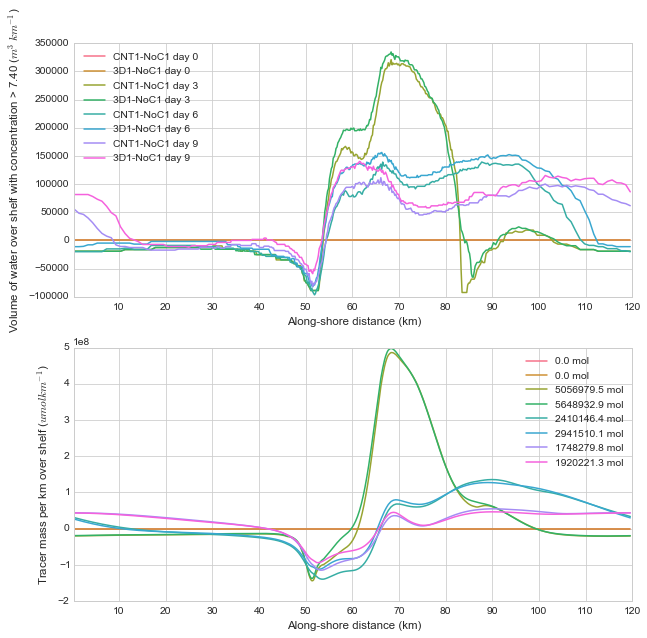

In [142]:
fig45=plt.figure(figsize=(10,10))
sns.set(context='paper', style='whitegrid', font='sans-serif', font_scale=1.3, rc={"lines.linewidth": 1.5})
with sns.color_palette("husl",8 ):
    for time in range(0,19,6):

        (WaterXCNT1, TrXCNT1) = HowMuchWaterX(Tr1CNT,MaskNoC,30,rA,hFacCNoC,drFNoC,time,nx,dxG)
        (WaterX3D1, TrX3D1) = HowMuchWaterX(Tr13D,MaskNoC,30,rA,hFacCNoC,drFNoC,time,nx,dxG)
        (WaterXNoC1, TrXNoC1) = HowMuchWaterX(Tr1NoC,MaskNoC,30,rANoC,hFacCNoC,drFNoC,time,nx,dxG)

        plt.subplot(2,1,1)
        plt.plot(xc[0,:],WaterXCNT1-WaterXNoC1,'-',label=('CNT1-NoC1 day %d' %(time/2.0)))
        plt.plot(xc[0,:],WaterX3D1-WaterXNoC1,'-',label=('3D1-NoC1 day %d' %(time/2.0)))

        plt.ylabel('Volume of water over shelf with concentration > 7.40 ($m^3 km^{-1}$)')
        plt.xlabel('Along-shore distance ($km$)')
        labels = [10,20,30,40, 50, 60, 70, 80,90,100,110,120]
        plt.xticks([10000,20000,30000,40000,50000,60000,70000,80000,90000,100000,110000,120000], labels)
        plt.legend(loc=0)

        plt.subplot(2,1,2)
        plt.plot(xc[0,:],TrXCNT1-TrXNoC1,'-',label=('%1.1f mol' %(np.sum((TrXCNT1-TrXNoC1)*dxG[0,:])*1.E-6)))
        plt.plot(xc[0,:],TrX3D1-TrXNoC1,'-',label=('%1.1f mol' %(np.sum((TrX3D1-TrXNoC1)*dxG[0,:])*1.E-6)))
        plt.ylabel('Tracer mass per km over shelf ($umol$ $km^{-1}$)')
        plt.xlabel('Along-shore distance ($km$)')
        labels = [10,20,30,40, 50, 60, 70, 80,90,100,110,120]
        plt.xticks([10000,20000,30000,40000,50000,60000,70000,80000,90000,100000,110000,120000], labels)

        plt.legend(loc=0)


    
    
    

('tracer limit is: ', 7.3974895)
('tracer limit is: ', 7.3974895)
('tracer limit is: ', 7.3974895)
('tracer limit is: ', 7.3974895)
('tracer limit is: ', 7.3974895)
('tracer limit is: ', 7.3974895)
('tracer limit is: ', 7.3974895)
('tracer limit is: ', 7.3974895)
('tracer limit is: ', 7.3974895)
('tracer limit is: ', 7.3974895)
('tracer limit is: ', 7.3974895)
('tracer limit is: ', 7.3974895)
('tracer limit is: ', 7.3974895)
('tracer limit is: ', 7.3974895)
('tracer limit is: ', 7.3974895)
('tracer limit is: ', 7.3974895)


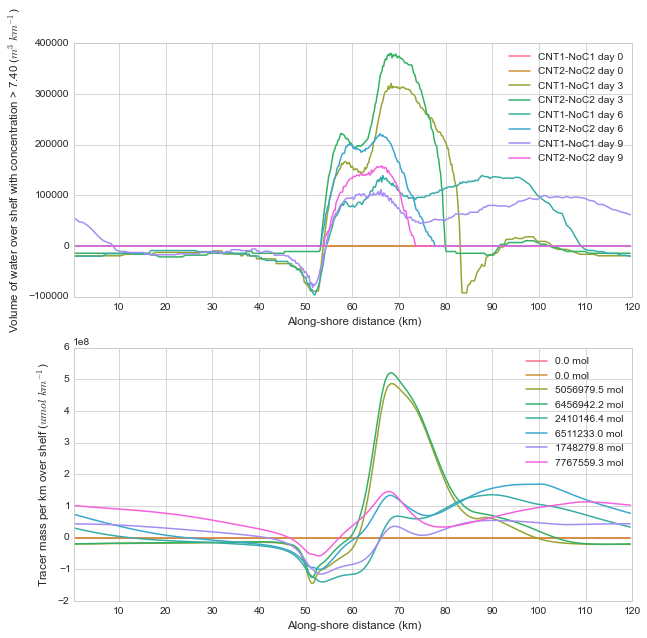

In [144]:
fig45=plt.figure(figsize=(10,10))
sns.set(context='paper', style='whitegrid', font='sans-serif', font_scale=1.3, rc={"lines.linewidth": 1.5})
with sns.color_palette("husl",8):
    for time in range(0,19,6):
    
        (WaterXCNT1, TrXCNT1) = HowMuchWaterX(Tr1CNT,MaskNoC,30,rA,hFacCNoC,drFNoC,time,nx,dxG)
        (WaterXCNT2, TrXCNT2) = HowMuchWaterX(Tr2CNT,MaskNoC,30,rA,hFacCNoC,drFNoC,time,nx,dxG)
        (WaterXNoC1, TrXNoC1) = HowMuchWaterX(Tr1NoC,MaskNoC,30,rANoC,hFacCNoC,drFNoC,time,nx,dxG)
        (WaterXNoC2, TrXNoC2) = HowMuchWaterX(Tr2NoC,MaskNoC,30,rANoC,hFacCNoC,drFNoC,time,nx,dxG)

        plt.subplot(2,1,1)
        plt.plot(xc[0,:],WaterXCNT1-WaterXNoC1,'-',label=('CNT1-NoC1 day %d' %(time/2.0)))
        #plt.plot(xc[0,:],WaterXNoC1,'d--',label=('NoC1 day %f1.1' %(time/2.0)))
        plt.plot(xc[0,:],WaterXCNT2-WaterXNoC2,'-',label=('CNT2-NoC2 day %d'%(time/2.0)))
        #plt.plot(xc[0,:],WaterXNoC2,'*-',label=('CNT2 day %f1.1' %(time/2.0)))

        plt.ylabel('Volume of water over shelf with concentration > 7.40 ($m^3 km^{-1}$)')
        plt.xlabel('Along-shore distance (km)')
        labels = [10,20,30,40, 50, 60, 70, 80,90,100,110,120]
        plt.xticks([10000,20000,30000,40000,50000,60000,70000,80000,90000,100000,110000,120000], labels)
        plt.legend(loc=0)

        plt.subplot(2,1,2)
        plt.plot(xc[0,:],TrXCNT1-TrXNoC1,'-',label=('%1.1f mol' %(np.sum((TrXCNT1-TrXNoC1)*dxG[0,:])*1.E-6)))
        #plt.plot(xc[0,:],TrXNoC1,'d--',label=('NoC1'))
        #plt.plot(xc[0,:],TrXNoC2,'*--',label=('NoC2'))
        plt.plot(xc[0,:],TrXCNT2-TrXNoC2,'-',label=('%1.1f mol' %(np.sum((TrXCNT2-TrXNoC2)*dxG[0,:])*1.E-6)))
        plt.ylabel('Tracer mass per km over shelf ($umol$ $km^{-1}$)')
        plt.xlabel('Along-shore distance (km)')
        labels = [10,20,30,40, 50, 60, 70, 80,90,100,110,120]
        plt.xticks([10000,20000,30000,40000,50000,60000,70000,80000,90000,100000,110000,120000], labels)
        plt.legend(loc=0)



